# Intro

Features:
  * **Age**: age of the patient [years]
  * **Sex**: sex of the patient [M: Male, F: Female]
  * **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
  * **RestingBP**: resting blood pressure [mm Hg]
  * **Cholesterol**: serum cholesterol [mm/dl]
  * **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
  * **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
  * **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
  * **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
  * **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
  * **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
  * **HeartDisease**: output class [1: heart disease, 0: Normal]

# Imports

In [1]:
import pandas as pd
import kagglehub
import os

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from statistics import mean
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
#kagglehub.login()

In [3]:
#path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
#print(path)
#os.listdir(path)

In [4]:
path = '/kaggle/input/heart-failure-prediction'

In [5]:
file_path = path + '/' + os.listdir(path)[0]
df = pd.read_csv(file_path)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


# Data Exploration

In [6]:
target = "HeartDisease"

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [8]:
df.describe().round(2)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [9]:
df['HeartDisease'].value_counts()

,count
HeartDisease,
1,508
0,410


In [10]:
print(df.isnull().sum())

#msno.matrix(df)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [11]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

918
918


## Numeric Features

array([<Axes: title={'center': 'Age'}>,
       <Axes: title={'center': 'RestingBP'}>,
       <Axes: title={'center': 'Cholesterol'}>,
       <Axes: title={'center': 'FastingBS'}>,
       <Axes: title={'center': 'MaxHR'}>,
       <Axes: title={'center': 'Oldpeak'}>,
       <Axes: title={'center': 'HeartDisease'}>], dtype=object)

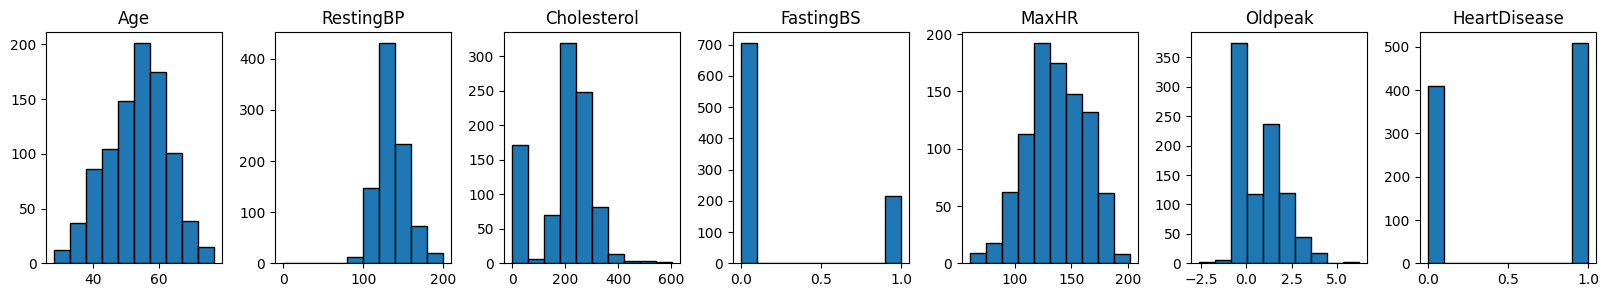

In [12]:
numeric_cols = df.select_dtypes(include='number').columns
fig, axis = plt.subplots(1, len(numeric_cols), figsize=(20,3))
df.hist(ax=axis, edgecolor='black', grid=False)

## Non-numeric features

In [13]:
non_numeric_features = df.select_dtypes(exclude='number').columns
print(non_numeric_features, '\n')
non_numeric_df = df[non_numeric_features]
non_numeric_df

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object') 



,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up
...,...,...,...,...,...
913,M,TA,Normal,N,Flat
914,M,ASY,Normal,N,Flat
915,M,ASY,Normal,Y,Flat
916,F,ATA,LVH,N,Flat


In [14]:
#Get number of unique values in each column
non_numeric_df.nunique()

,0
Sex,2
ChestPainType,4
RestingECG,3
ExerciseAngina,2
ST_Slope,3


### Encoding non-numeric features

### Label encoding for categories that can be binary

In [15]:
#LabelEncoder assigns integers in arbitrary order based on lexicographical sorting
le = LabelEncoder()
df['Sex_binary'] = le.fit_transform(df['Sex'])
df['ExerciseAngina_binary'] = le.fit_transform(df['ExerciseAngina'])
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_binary,ExerciseAngina_binary
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,1,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,1,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,1,0
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,1,0
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,1,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,0,0


### Ordinal Encoder for categorical variables with meaningful order

In [16]:
# ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
encoder = OrdinalEncoder(categories=[['Down', 'Flat', 'Up']])
df['ST_Slope_encoded'] = encoder.fit_transform(df[['ST_Slope']])
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_binary,ExerciseAngina_binary,ST_Slope_encoded
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,1,0,2.0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,0,1.0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,1,0,2.0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0,1,1.0
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,1,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,1,0,1.0
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,1,0,1.0
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,1,1,1.0
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,0,0,1.0


### One Hot Encoding for categories that are not binary and do not have meaningful order

In [17]:
ohe = OneHotEncoder(sparse_output=False)
encoded_data = ohe.fit_transform(df[['ChestPainType', 'RestingECG']])
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['ChestPainType', 'RestingECG']))
encoded_df = encoded_df.drop(columns=['RestingECG_Normal', 'ChestPainType_ASY']) # Removing baseline variables (no chest pain and normal ECG) to prevent collinearity problems
encoded_df

,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
913,0.0,0.0,1.0,0.0,0.0
914,0.0,0.0,0.0,0.0,0.0
915,0.0,0.0,0.0,0.0,0.0
916,1.0,0.0,0.0,1.0,0.0


In [18]:
df = df.merge(encoded_df, left_index=True, right_index=True)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_binary,ExerciseAngina_binary,ST_Slope_encoded,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,1,0,2.0,1.0,0.0,0.0,0.0,0.0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,0,1.0,0.0,1.0,0.0,0.0,0.0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,1,0,2.0,1.0,0.0,0.0,0.0,1.0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,1,0,2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,1,0,1.0,0.0,0.0,1.0,0.0,0.0
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,0,0,1.0,1.0,0.0,0.0,1.0,0.0


In [19]:
# Remove unencoded categorical variables
df = df.drop(columns = non_numeric_features)

# Print non-numeric columns to ensure all columns are numeric
print('Non numeric columns:', df.select_dtypes(exclude='number').columns)

Non numeric columns: Index([], dtype='object')


In [20]:
df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_binary,ExerciseAngina_binary,ST_Slope_encoded,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_ST
0,40,140,289,0,172,0.0,0,1,0,2.0,1.0,0.0,0.0,0.0,0.0
1,49,160,180,0,156,1.0,1,0,0,1.0,0.0,1.0,0.0,0.0,0.0
2,37,130,283,0,98,0.0,0,1,0,2.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0
4,54,150,195,0,122,0.0,0,1,0,2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,1.0,0.0,0.0,1.0,0.0,0.0
914,68,144,193,1,141,3.4,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0
915,57,130,131,0,115,1.2,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0
916,57,130,236,0,174,0.0,1,0,0,1.0,1.0,0.0,0.0,1.0,0.0


# Feature Selection

<Axes: >

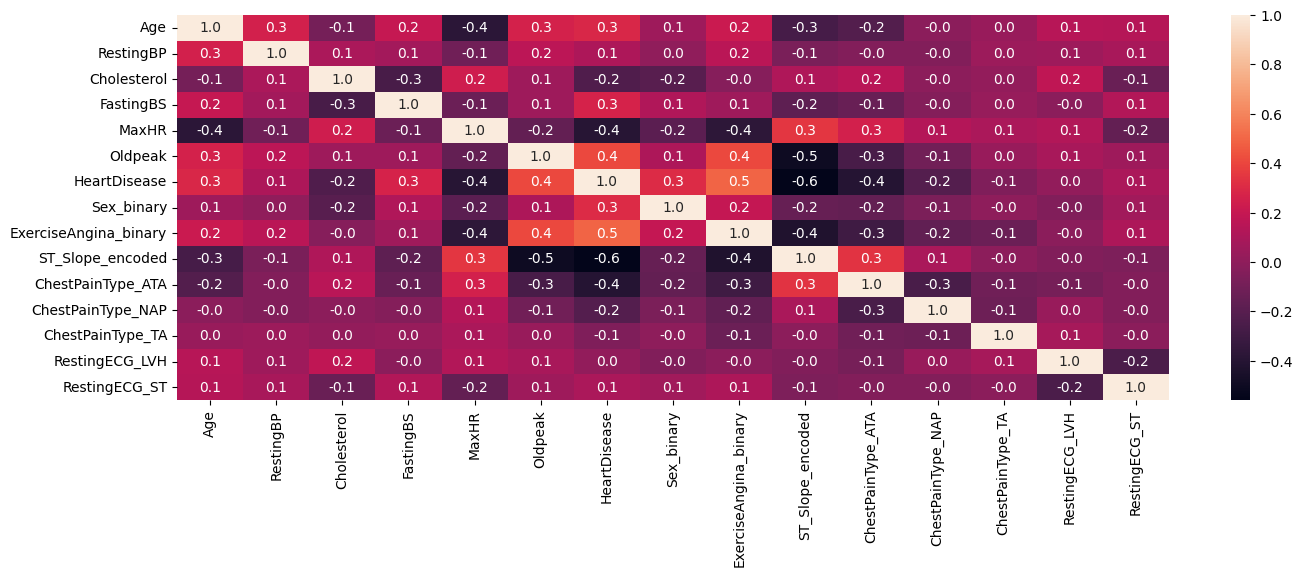

In [21]:
plt.figure(figsize = (16,5))
sns.heatmap(df.corr(), annot=True, fmt=".1f")

# Models

In [22]:
features_df = df.drop(columns=[target])
y=df[target].values

In [23]:
# Create validation set
features_train_test, features_validate, target_train_test, target_validate = train_test_split(features_df, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
print('Features for training', features_train_test.shape)
print('Features for validation', features_validate.shape)
print('Target for training', target_train_test.shape)
print('Target for validation', target_validate.shape)

Features for training (734, 14)
Features for validation (184, 14)
Target for training (734,)
Target for validation (184,)


In [25]:
kf_data = {}
accuracies={}

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X=features_train_test)):

    X_train, X_test = features_train_test.iloc[train_index], features_train_test.iloc[test_index]
    y_train, y_test = target_train_test[train_index], target_train_test[test_index]

    # Apply scaler inside kfold to prevent data leakage
    ro_scaler=MinMaxScaler()
    X_train= ro_scaler.fit_transform(X_train)
    X_test = ro_scaler.transform(X_test)

    kf_data[fold] = {'X_train': X_train,
                     'X_test': X_test,
                     'y_train': y_train,
                     'y_test': y_test}

## Non Tree Based Models

### Logistic Regression
Logistic regression is a calculation used to predict a binary outcome.

Like linear regression, it first computes a weighted sum of the inputs (this linearity is why it can't capture complex relationships). Then it passes the result through the sigmoid function to squash the output to a probability between 0 and 1. If the output is greater tha 0.5, the model predicts 1, else it predicts.

✔️ Pros:
*   Simple and fast.
*   Output is probabilistic, not just a label.
*   Works well when the data is linearly separable (or close to it).
*   Easy to regularize (to prevent overfitting).
*   Good baseline for binary classification.
*   Provides an interpretable model (coefficients show feature importance).

❌ Cons:
*   Doesn’t capture complex patterns (e.g., interactions, non-linearity).
*   Can be sensitive to outliers or irrelevant features.

⚙️ Key Parameters in sklearn.linear_model.LogisticRegression
*   `penalty`: Regularization type ('l2' by default).
*   `C`: Inverse of regularization strength (smaller = stronger regularization).
*   `solver`: Algorithm to use ('lbfgs', 'liblinear', etc.).
*   `max_iter`: Max number of iterations to converge.


In [26]:
#Create somewhere to store results
lr_accuracies = []

# Create a logistic regression model
model = LogisticRegression(max_iter=200, random_state=42)

for fold, data_dict in kf_data.items():
    X_train = data_dict['X_train']
    X_test = data_dict['X_test']
    y_train = data_dict['y_train']
    y_test = data_dict['y_test']

    # Train logistic regression model
    model.fit(X_train, y_train)

    # Validate the model
    y_pred = model.predict(X_test)

    # Get accuracy
    accuracy = accuracy_score(y_test, y_pred)
    lr_accuracies.append(accuracy)
    print(f"Fold {fold + 1} validation accuracy: {accuracy:.4f}")

accuracies['logstic_regression'] = [mean(lr_accuracies)]
pd.DataFrame(accuracies, index=['Average Accuracy']).T

Fold 1 validation accuracy: 0.8367
Fold 2 validation accuracy: 0.8639
Fold 3 validation accuracy: 0.8435
Fold 4 validation accuracy: 0.8367
Fold 5 validation accuracy: 0.8630


,Average Accuracy
logstic_regression,0.848793


### K-Nearest Neighbors (KNN)
The model calculates the distance (usually Euclidean) between the test point and all other points in the training set, and then picks the K closest points. The most common label among those neighbors is assigned as the prediction.

✔️ Pros:
*   Simple and easy to understand.
*   No training phase — just stores the data, making it fast for small datasets.
*   Can capture complex decision boundaries (non-linear relationships).
*   Works well for multi-class classification.
*   Very flexible — the number of neighbors, distance metric, and other parameters can be easily adjusted.

❌ Cons:
*   Computationally expensive at prediction time, especially with large datasets (since it needs to compute distances to every point)
*   Sensitive to irrelevant or redundant features, and scales poorly with high-dimensional data (curse of dimensionality).
*   Needs careful choice of K: too small (overfitting), too large (underfitting).
*   Doesn’t perform well with imbalanced data (minority class might be ignored).

⚙️ Key Parameters in sklearn.neighbors.KNeighborsClassifier:
*   `n_neighbors`: Number of neighbors to use for prediction.
*   `weights`: How to weight neighbors (uniform or distance-based).
*   `algorithm`: Algorithm used to compute the nearest neighbors (Default is 'auto',  he algorithm automatically chooses the best method based on the data provided.).
*   `metric`: Distance metric to use (e.g., 'euclidean', 'manhattan')

##### **Experimenting to find K: GridSearchCV**
GridSearchCV is a brute-force search method that tries every combination of
hyperparameters you give it, trains a model for each, and selects the best
one based on cross-validation performance.

Parameters:
*   `cv`: Cross-validation splitting strategy
*   `scoring`: Evaluation Metric
*   `verbose (int)` Controls the verbosity: the higher, the more messages.
    *   1 : the computation time for each fold and parameter candidate is displayed;
    *   2 : the score is also displayed;
    *   3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.



Accessing results:
*   `.best_estimator_.` Stores the best model
*   `.best_params_.` Stores its parameters
*   `.cv_results_.` contains detailed results for all combinations

In [33]:
# Initialize KNN classifier
knn = KNeighborsClassifier()

# Define the parameter grid (exploring different values of K)
param_grid = {
    'n_neighbors': [i for i in range(1, 15, 1)] + [i for i in range(15, 40, 10)], #increasing difference as value increases
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV with KNN, parameter grid, and KFold cross-validation
grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           cv=kf)

# Fit the model (this will evaluate each K value)
grid_search.fit(X_train, y_train)

# Get the mean test scores for each K value for plotting
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Print the best K value and its accuracy
print(f"Best K: {grid_search.best_params_['n_neighbors']}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best model on the test set
best_knn_model = grid_search.best_estimator_
test_accuracy = best_knn_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Best K: 11
Best Cross-Validation Accuracy: 0.8520
Test Accuracy: 0.8082


In [34]:
# Extract fold-wise accuracies and weights
results_df = pd.DataFrame(grid_search.cv_results_)
param_cols = [col for col in results_df.columns if col.startswith('param_')]
results_df = results_df[param_cols + ['mean_test_score']]

# Plot results
fig = px.line(results_df, markers=True,  x="param_n_neighbors", y="mean_test_score", color='param_weights', title='How selected hyperparameters impact accuracy')
fig.update_layout(yaxis=dict(range=[0.6, 1]))
fig.show()


##### Running KNN Model

In [29]:
# I chose to stick with k=5
resulting_accuracy = results_df[(results_df['param_n_neighbors'] == 5) & (results_df['param_weights'] == 'distance')]['mean_test_score'].item()

accuracies['KNN'] = [resulting_accuracy]
pd.DataFrame(accuracies, index=['Average Accuracy']).T

,Average Accuracy
logstic_regression,0.848793
KNN,0.846893


### ❌ Naive Bayes

### ❌ SVM

## Tree Based Methods

### Decision Tree
A Decision Tree is a flowchart-like structure used for classification (and regression). It splits the data based on feature values to create branches, leading to decisions at the leaves.

✔️ Pros:
*   Interpretable and easy to visualize: You can follow the decision path from root to leaf.
*   No need for feature scaling: Works well with raw data, including categorical and numerical features.
*   Captures non-linear relationships: Can model complex decision boundaries.
*   Handles missing values and irrelevant features relatively well.
*   Requires little data preprocessing: No need for one-hot encoding (some implementations support this natively).

❌ Cons:
*   Prone to overfitting, poor generalization: Especially if the tree is deep or not pruned.
*   Unstable: The tree-building process uses greedy, recursive splits (e.g., choosing the best feature to split at each node). If your dataset changes slightly (e.g., one new data point or a slight change in feature values), the best split at a node might change. This change cascades down the tree, resulting in a completely different structure.
*   Biased with imbalanced classes or skewed features: May favor features with more levels.

⚙️ Key Parameters in sklearn.neighbors.KNeighborsClassifier:
*   `max_depth`	Limits how deep the tree can go. Prevents overfitting. Critical for tuning.
*   `min_samples_split`	Controls how many samples are needed to split a node. Higher = less overfitting.
*   `min_samples_leaf`	Ensures leaves have enough data to generalize. Helps smooth predictions.


In [30]:
# Create model
model = DecisionTreeClassifier(criterion="entropy")

param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 10, None], #default = None
    'min_samples_split': [2, 5, 10], # default = 2
    'min_samples_leaf': [1, 2, 4], # default = 1
    'criterion': ['gini', 'entropy'] # default = gini
}


grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=kf,
                           verbose=1)

# Fit the model with cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
test_accuracy = best_model.score(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

accuracies['decision_tree'] = [test_accuracy]
pd.DataFrame(accuracies, index=['Average Accuracy']).T

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Test Accuracy: 0.8493


,Average Accuracy
logstic_regression,0.848793
KNN,0.846893
decision_tree,0.849315


### ❌ Random Forest Classifier

### ❌ XGBoost

# Final Evaluation

In [35]:
pd.DataFrame(accuracies, index=['Average Accuracy']).T

,Average Accuracy
logstic_regression,0.848793
KNN,0.846893
decision_tree,0.849315
